In [1]:
# Google Colab setup
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
os.chdir("drive/My Drive/adl4cv")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
drive.mount('/content/drive', force_remount=True)

In [0]:
# ONLY NECESSARY FOR LOCAL EXECUTION (WORKS WITHOUT THIS CELL IN GOOGLE COLAB)
# Setup that is necessary for jupyter notebook to find sibling-directories
# see: https://stackoverflow.com/questions/34478398/import-local-function-from-a-module-housed-in-another-directory-with-relative-im

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [0]:
# FROM i2dl for nice setup
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# supress cluttering warnings in solutions
import warnings
warnings.filterwarnings('ignore')

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [0]:
# Imports for this notebook

from training.solver import Solver
from training.sequence_dataloader_of import FaceForensicsVideosDataset, ToTensor
from torch.utils import data
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torchvision.transforms

Load Data


In [6]:
sequence = "sequences_299x299_5seq@10frames_skip_5_uniform"

original_location = "/content/drive/My Drive/FaceForensics_Sequences/original_sequences/youtube/c40/" + sequence
deepfake_location = "/content/drive/My Drive/FaceForensics_Sequences/manipulated_sequences/Deepfakes/c40/" + sequence

data_location = [original_location, deepfake_location]

data_dict = {"dataset-" + str(i): data_location[i] for i in range(len(data_location))}

dataset = FaceForensicsVideosDataset(data_location, 5, transform=ToTensor(), max_number_videos_per_directory=2)

Loading directory 1/2: /content/drive/My Drive/FaceForensics_Sequences/original_sequences/youtube/c40/sequences_299x299_5seq@10frames_skip_5_uniform


Reached maximum number of videos per directory (2), will skip the rest.

Loading directory 2/2: /content/drive/My Drive/FaceForensics_Sequences/manipulated_sequences/Deepfakes/c40/sequences_299x299_5seq@10frames_skip_5_uniform


Reached maximum number of videos per directory (2), will skip the rest.



In [7]:
dataset_args = {
    "batch_size": 4,
    "validation_percentage": 0.2,
    "sequence": sequence,
    **data_dict
}


# Creating data indices for training and validation splits:
train_indices, val_indices = dataset.get_train_val_lists(1 - dataset_args["validation_percentage"], dataset_args["validation_percentage"])


# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=dataset_args["batch_size"], 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=dataset_args["batch_size"],
                                                sampler=valid_sampler)

dataset_args["train_len"] = len(train_loader)
dataset_args["val_len"] = len(validation_loader)

print("All samples", dataset.__len__())

print("Train samples: {}".format(len(train_loader)))
print("Validation samples: {}".format(len(validation_loader)))

All samples 20
Train samples: 4
Validation samples: 1


Load Model + Tensorboard


In [8]:
# Start tensorboard
%load_ext tensorboard
%tensorboard --logdir runs

In [9]:
# Load baseline model
model_args={
    "model_choice": "xception",
    "num_frames": 5,
    "dropout": 0.0,
    "drop_blocks": 2
}

from networks.network_of_conv import OFModel

model = OFModel(model_choice=model_args["model_choice"],
                      num_frames=model_args["num_frames"],
                      dropout=model_args["dropout"],
                      drop_blocks=model_args["drop_blocks"])
model.train_only_last_layer()


Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth" to /root/.cache/torch/checkpoints/xception-43020ad28.pth
100%|██████████| 87.4M/87.4M [04:17<00:00, 355kB/s]


In [10]:
# Create unique ID for this training process for saving to disk.

from datetime import datetime
import uuid
now = datetime.now() # current date and time
id = str(uuid.uuid1())
id_suffix = now.strftime("%Y-%b-%d_%H:%M:%S") + "_" + id

log_dir = "runs/trash/" + id_suffix
print("log_dir:", log_dir)

log_dir: runs/trash/2020-Feb-02_14:25:25_da7f5f98-45c7-11ea-b1ca-0242ac1c0002


Training

In [11]:
# Configure solver
extra_args = {
    **model_args,
    **dataset_args
}

solver = Solver(optim=torch.optim.Adam,
                optim_args={ "lr": 5e-4,
                             "betas": (0.9, 0.999),
                             "eps": 1e-8,
                             "weight_decay": 0.001}, # is the l2 regularization parameter, see: https://pytorch.org/docs/stable/optim.html
                loss_func=torch.nn.CrossEntropyLoss(),
                extra_args=extra_args,
                log_dir=log_dir)

solver.train(model, train_loader, validation_loader, num_epochs=10, log_nth=1)

Hyperparameters of this solver: {'loss function': 'CrossEntropyLoss', 'optimizer': 'Adam', 'learning rate': 0.0005, 'weight_decay': 0.001, 'model_choice': 'xception', 'num_frames': 5, 'dropout': 0.0, 'drop_blocks': 2, 'batch_size': 4, 'validation_percentage': 0.2, 'sequence': 'sequences_299x299_5seq@10frames_skip_5_uniform', 'dataset-0': '/content/drive/My Drive/FaceForensics_Sequences/original_sequences/youtube/c40/sequences_299x299_5seq@10frames_skip_5_uniform', 'dataset-1': '/content/drive/My Drive/FaceForensics_Sequences/manipulated_sequences/Deepfakes/c40/sequences_299x299_5seq@10frames_skip_5_uniform', 'train_len': 4, 'val_len': 1}
START TRAIN on device: cuda:0
[Iteration 1/4] TRAIN loss: 0.6596387028694153
[Iteration 2/4] TRAIN loss: 0.7088379859924316
[Iteration 3/4] TRAIN loss: 0.7107909917831421
[Iteration 4/4] TRAIN loss: 0.6388264298439026
[EPOCH 1/10] TRAIN mean acc/loss: 0.47916666666666663/0.6795234680175781
[Iteration 1/1] Val loss: 0.6939123272895813
[EPOCH 1/10] VAL m

Use Testset

In [0]:
# Load test data for SAME FAKE SET

same_test_data_location = ["/content/drive/My Drive/FaceForensics_Sequences/FaceForensics_Testset/original_sequences/youtube/c40/" + sequence,
                 "/content/drive/My Drive/FaceForensics_Sequences/FaceForensics_Testset/manipulated_sequences/NeuralTextures/c40/" + sequence]
same_test_dataset = FaceForensicsVideosDataset(same_test_data_location, 5, transform=ToTensor())

same_test_indices = range(len(same_test_dataset))

same_test_sampler = SubsetRandomSampler(same_test_indices)

same_test_loader = torch.utils.data.DataLoader(same_test_dataset, batch_size=4, 
                                           sampler=same_test_sampler)

print("Length of same fake test set: {}".format(len(same_test_dataset)))

Loading directory 1/2: /content/drive/My Drive/FaceForensics_Sequences/FaceForensics_Testset/original_sequences/youtube/c40/sequences_299x299_5seq@10frames_skip_5_uniform


Loading directory 2/2: /content/drive/My Drive/FaceForensics_Sequences/FaceForensics_Testset/manipulated_sequences/NeuralTextures/c40/sequences_299x299_5seq@10frames_skip_5_uniform


Length of same fake test set: 100


In [0]:
# Start testing

solver.test(model, same_test_loader, test_prefix="Same_Fake_Method", log_nth=10)

[Iteration 1/25] TEST loss: 0.7699233293533325
[Iteration 11/25] TEST loss: 0.5727242231369019
[Iteration 21/25] TEST loss: 0.6547252535820007
[TEST] mean acc/loss: 0.74/0.5695606470108032


In [0]:
# Load test data for DIFFERENT FAKE SET

faceswap_test_data_location = ["/content/drive/My Drive/FaceForensics_Sequences/FaceForensics_Testset/original_sequences/youtube/c40/sequences_299x299_5seq@10frames_skip_5_uniform",
                 "/content/drive/My Drive/FaceForensics_Sequences/FaceForensics_Testset/manipulated_sequences/FaceSwap/c40/sequences_299x299_5seq@10frames_skip_5_uniform"]

face2face_test_data_location = ["/content/drive/My Drive/FaceForensics_Sequences/FaceForensics_Testset/original_sequences/youtube/c40/sequences_299x299_5seq@10frames_skip_5_uniform",
                 "/content/drive/My Drive/FaceForensics_Sequences/FaceForensics_Testset/manipulated_sequences/Face2Face/c40/sequences_299x299_5seq@10frames_skip_5_uniform"]

neuraltextures_test_data_location = ["/content/drive/My Drive/FaceForensics_Sequences/FaceForensics_Testset/original_sequences/youtube/c40/sequences_299x299_5seq@10frames_skip_5_uniform",
                 "/content/drive/My Drive/FaceForensics_Sequences/FaceForensics_Testset/manipulated_sequences/Deepfakes/c40/sequences_299x299_5seq@10frames_skip_5_uniform"]

pristine_test_data_location = ["/content/drive/My Drive/FaceForensics_Sequences/FaceForensics_Testset/original_sequences/youtube/c40/sequences_299x299_5seq@10frames_skip_5_uniform"]

test_locations = [faceswap_test_data_location, face2face_test_data_location, neuraltextures_test_data_location, pristine_test_data_location]
names= ["Faceswap", "Face2Face", "NeuralTextures", "pristine"]
for i, dif_test_data_location in enumerate(test_locations):
    dif_test_dataset = FaceForensicsVideosDataset(dif_test_data_location, 5, transform=ToTensor())

    dif_test_indices = range(len(dif_test_dataset))

    dif_test_sampler = SubsetRandomSampler(dif_test_indices)

    dif_test_loader = torch.utils.data.DataLoader(dif_test_dataset, batch_size=4, 
                                            sampler=dif_test_sampler)

    print("Length of dif fake test set: {}".format(len(same_test_dataset)))
    print(names[i])
    solver.test(model, dif_test_loader, test_prefix="Different_Fake_Method", log_nth=10)

Loading directory 1/2: /content/drive/My Drive/FaceForensics_Sequences/FaceForensics_Testset/original_sequences/youtube/c40/sequences_299x299_5seq@10frames_skip_5_uniform


Loading directory 2/2: /content/drive/My Drive/FaceForensics_Sequences/FaceForensics_Testset/manipulated_sequences/FaceSwap/c40/sequences_299x299_5seq@10frames_skip_5_uniform


Length of dif fake test set: 100
Faceswap
[Iteration 1/25] TEST loss: 1.063597559928894
[Iteration 11/25] TEST loss: 0.6021175980567932
[Iteration 21/25] TEST loss: 0.4071460962295532
[TEST] mean acc/loss: 0.5/0.8057708144187927
Loading directory 1/2: /content/drive/My Drive/FaceForensics_Sequences/FaceForensics_Testset/original_sequences/youtube/c40/sequences_299x299_5seq@10frames_skip_5_uniform


Loading directory 2/2: /content/drive/My Drive/FaceForensics_Sequences/FaceForensics_Testset/manipulated_sequences/Face2Face/c40/sequences_299x299_5seq@10frames_skip_5_uniform


Length of dif fake test set: 100
Face2Face
[Iteration 1/25] TEST loss: 0.8134999871253967
[Iteration 11/25] TEST loss: 0.8140009045600891
[Iteration 21/25] TEST loss: 0.8039069175720215
[TEST] mean acc/loss: 0.62/0.6892460584640503
Loading directory 1/2: /content/drive/My Drive/FaceForensics_Sequences/FaceForensics_Testset/original_sequences/youtube/c40/sequences_299x299_5seq@10frames_skip_5_uniform


Loading directory 2/2: /content/drive/My Drive/FaceForensics_Sequences/FaceForensics_Testset/manipulated_sequences/Deepfakes/c40/sequences_299x299_5seq@10frames_skip_5_uniform


Length of dif fake test set: 100
NeuralTextures
[Iteration 1/25] TEST loss: 0.6537129878997803
[Iteration 11/25] TEST loss: 0.7925689220428467
[Iteration 21/25] TEST loss: 0.667270302772522
[TEST] mean acc/loss: 0.6/0.7083646655082703
Loading directory 1/1: /content/drive/My Drive/FaceForensics_Sequences/FaceForensics_Testset/original_sequences/youtube/c40/sequences_299x299_5seq@10frames_skip_5_uniform


Length of dif fake test set: 100
pristine
[Iteration 1/13] TEST loss: 0.32941266894340515
[Iteration 11/13] TEST loss: 0.41653740406036377
[TEST] mean acc/loss: 0.8269230769230769/0.47719648480415344


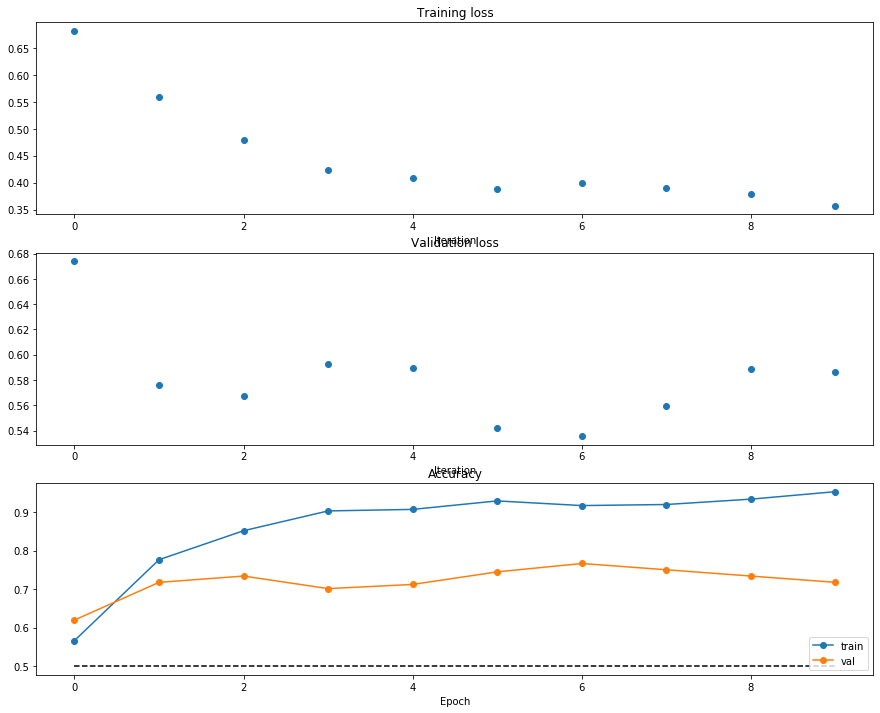

In [0]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.plot(solver.train_loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Validation loss')
plt.plot(solver.val_loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(3, 1, 3)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

Save model


In [0]:
def save_model(modelname, model):
    filepath = "/content/drive/My Drive/adl4cv/" + modelname + ".pt"
    torch.save(model.state_dict(), filepath)

In [0]:
save_model("of_to_nf" + id_suffix, model)